# Initialisations

In [1]:
library(rJava)
library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
library(factoextra)
library(xlsx)
theme_set(theme_classic())

corrplot 0.84 loaded
Warning message:
“package ‘reshape2’ was built under R version 3.4.3”Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: xlsxjars


# Plot Functions

In [2]:
adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis)
  print(g)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
    ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Import du dataset complet XLSX

In [8]:
# import du fichier complet
rtupb_vbpps_complete <- read.xlsx(file = "datasets/RTUPB-VBPPS.xlsx", sheetIndex = 1, header = 1, startRow = 2)[,-1]
attributes(rtupb_vbpps_complete)$names = c('Age','Comorbidite','Duree_Traitement_Medical','Porteur_Sonde','IPSS','QoL','Qmax','PSA','Volume_Prostatique','Residu_Post_Mictionnel','Indication','Anesthesie','Evenement','Technique','Transfusion','Temps_Operation','Volume_Reseque','Delai_Ablation','Caillotage','Reprise_Bloc',
    'M1_IPSS','M1_QoL','M1_Qmax','M3_IPSS','M3_QoL','M3_Qmax','M6_IPSS','M6_QoL','M6_Qmax','M9_IPSS','M9_QoL','M9_Qmax','M12_IPSS','M12_QoL','M12_Qmax','M15_IPSS','M15_QoL','M15_Qmax','M18_IPSS','M18_QoL','M18_Qmax')

# 1. Considérations

## 1.1 Typage des données

[Expliquer le choix dans le typage des données]

In [19]:
# Cast des variables booléennes
rtupb_vbpps_complete$Comorbidite<-as.factor(rtupb_vbpps_complete$Comorbidite)
rtupb_vbpps_complete$Porteur_Sonde<-as.factor(rtupb_vbpps_complete$Porteur_Sonde)
rtupb_vbpps_complete$Caillotage<-as.factor(rtupb_vbpps_complete$Caillotage)
rtupb_vbpps_complete$Transfusion<-as.factor(rtupb_vbpps_complete$Transfusion)
rtupb_vbpps_complete$Reprise_Bloc<-as.factor(rtupb_vbpps_complete$Reprise_Bloc)
rtupb_vbpps_complete$Anesthesie <- as.factor(rtupb_vbpps_complete$Anesthesie)
rtupb_vbpps_complete$Indication<-as.factor(rtupb_vbpps_complete$Indication)
rtupb_vbpps_complete$Evenement<-as.factor(rtupb_vbpps_complete$Evenement)
rtupb_vbpps_complete$Technique<-as.factor(rtupb_vbpps_complete$Technique)

## 1.2  Données manquantes

Les individus porteur de sonde ne sont pas concernés par la variable 'Résidu post mictionnel'. Ils n'ont donc pas de valeurs pour cette feature. 
Ici, plusieurs scénarios sont possibles. On pourrait, par exemple, enlever la variable 'Résidu post mictionnel' ou alors baser notre analyse uniquement sur les patients qui ne sont pas porteurs de sonde.

Le jeu de données n'étant pas très important, nous faisons le choix de ne pas enlever d'individus supplémentaires. Nous enlèverons donc la variable 'Résidu Post mictionnel' ainsi que la variable 'Qmax' qui n'est pas relevée pour les individus porteurs de sonde.

De plus le volume réséqué n'est disponible que pour la technique opératoire RTUPB. Nous pensons que cette donnée va fausser l'analyse et ne sera pas pertinente dans la discrimination des techniques opératoires. Nous faisons le choix de la supprimer du jeu de données.

Enfin, nous avons noté que certaines variables sont constantes à tout le tableau : 'Evenement', 'Transfusion' et 'Reprise Bloc'. Nous faisons le choix de les supprimer malgré que cela nous poserait un problème dans l'éventualité où des nouveaux patients seraient intégrés à l'étude avec des valeurs différentes de celles aujourd'hui observées.

Résumé : Jeu de données complet 
   \- moins Résidu post mictionnel
   \- moins Volume Réséqué
   \- moins Qmax
   \- moins Evenement
   \- moins Transfusion
   \- moins Reprise Bloc

### 1.3 Individus dupliqués ?

Nous notons que certains individus sont étrangement proches, avec 1 valeur différente sur 1 seule variable. Dans une situation réelle nous aurions demandé au client de faire la lumière sur ce jeu de données et de vérifier qu'il n'y a pas d'erreur. Ces individus ont également des valeurs éloignées de la moyenne sur certaines features. Ils vont compromettre le clustering mais nous faisons le choix de les garder.

[Donner des exemples]

# Préparation du jeu de données

In [21]:
# on garde tous les individus
# on supprime les features que nous avons choisies d'ignorer
rtupb_vbpps <- subset(rtupb_vbpps_complete,select=-c(Volume_Reseque,Residu_Post_Mictionnel,Qmax,Evenement,Transfusion,Reprise_Bloc))

In [22]:
# 15 premières colonnes du dataset -> pré-opératoire, les dernières -> post-opératoire
rtupb_vbpps_pre <- rtupb_vbpps[,1:14]
rtupb_vbpps_post <- rtupb_vbpps[,15:35]

In [23]:
# On crée des dataframes ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
rtupb_vbpps_num <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.numeric(x))]
rtupb_vbpps_pre_num = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.numeric(x))]
rtupb_vbpps_post_num = rtupb_vbpps_post[,sapply(rtupb_vbpps_post, function(x) is.numeric(x))]

# On crée des dataframes ne comportant que les données booléennes, ordinales ou catégoriques
rtupb_vbpps_cat <- rtupb_vbpps[,sapply(rtupb_vbpps, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
rtupb_vbpps_pre_cat = rtupb_vbpps_pre[,sapply(rtupb_vbpps_pre, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
rtupb_vbpps_post_cat = rtupb_vbpps_post[,sapply(rtupb_vbpps_post, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]

# 2. Analyse descriptive

## 2.1 Pré-opératoire

### 2.1.2 Distributions

In [24]:
# on divise le dataset en 2 pour voir les techniques séparément
rtupb_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 1),]
vbpps_pre <- rtupb_vbpps_pre[which(rtupb_vbpps_pre$Technique == 2),]

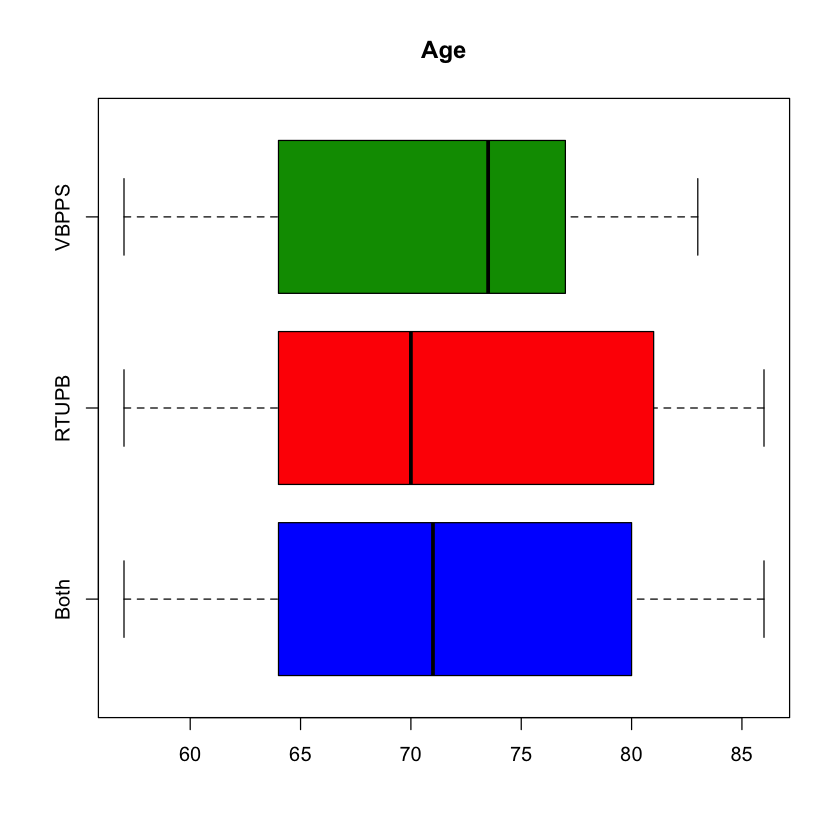

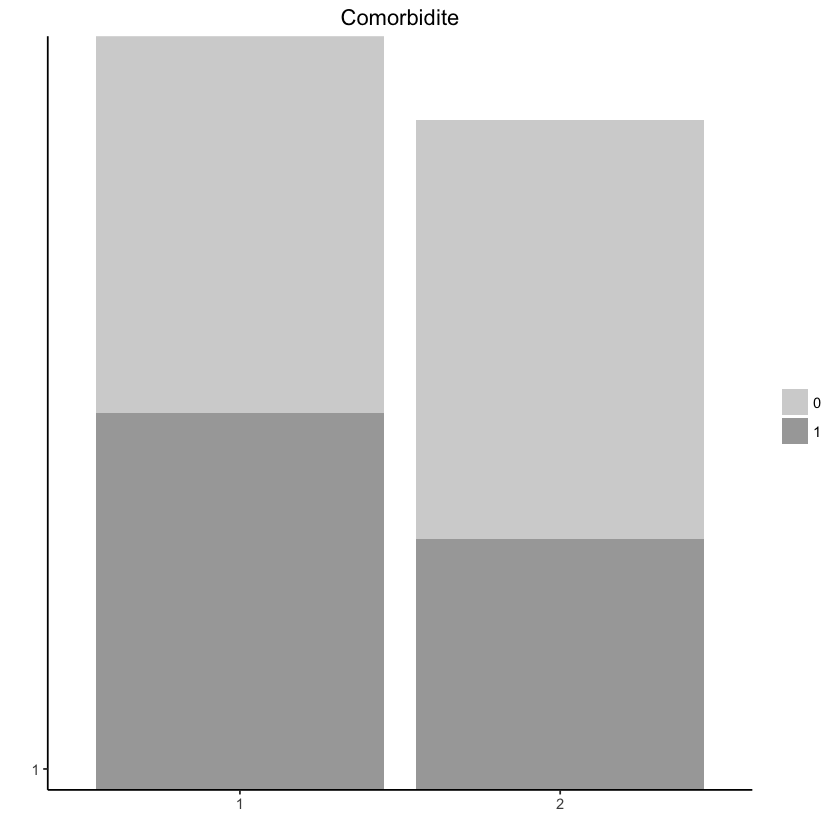

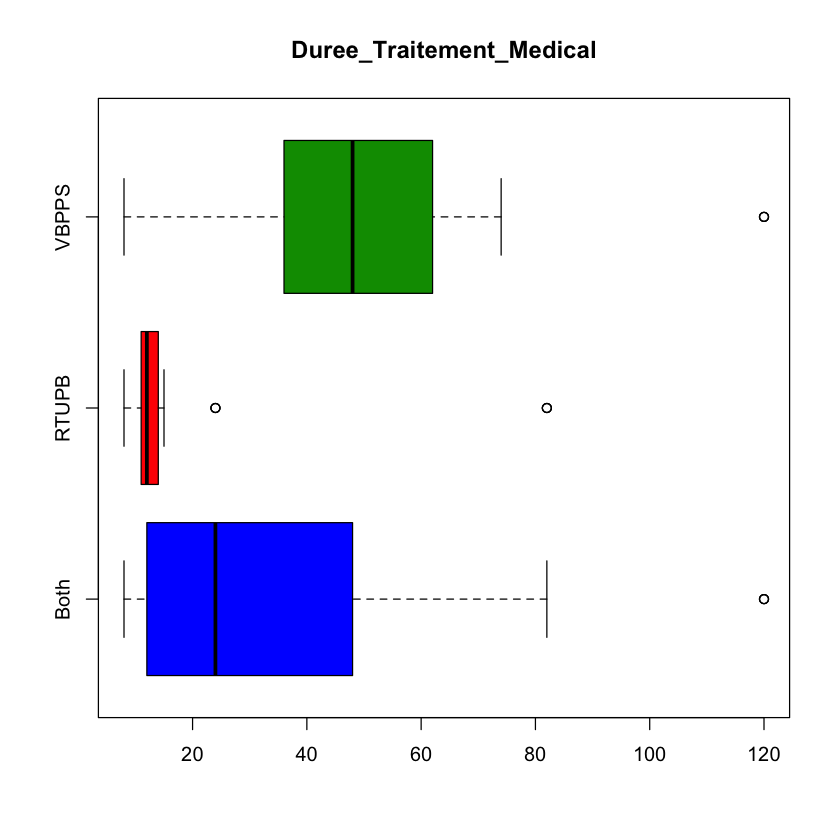

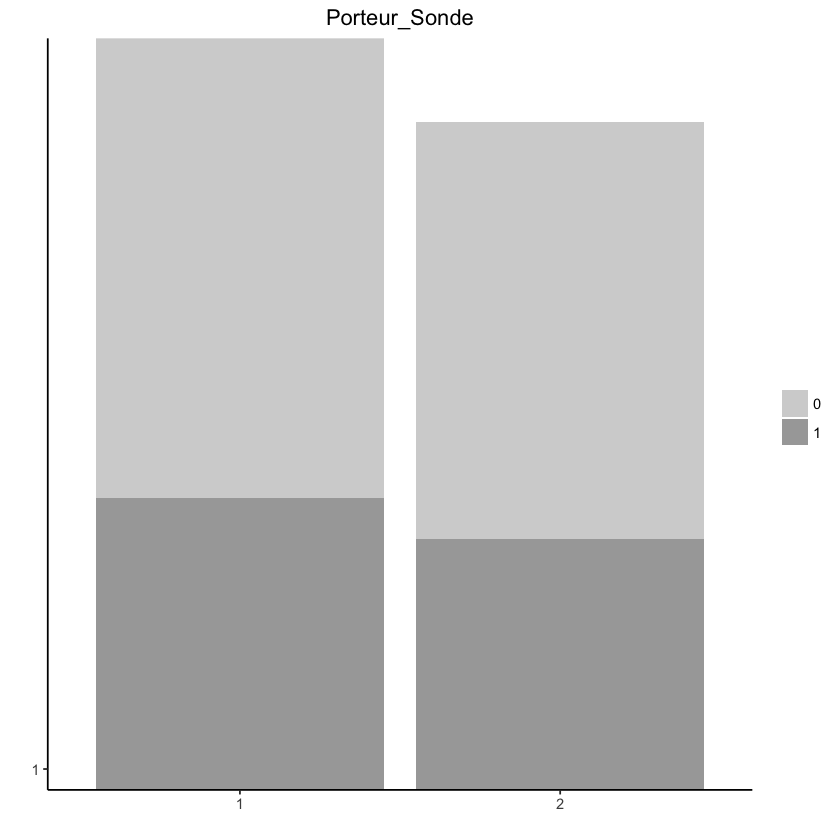

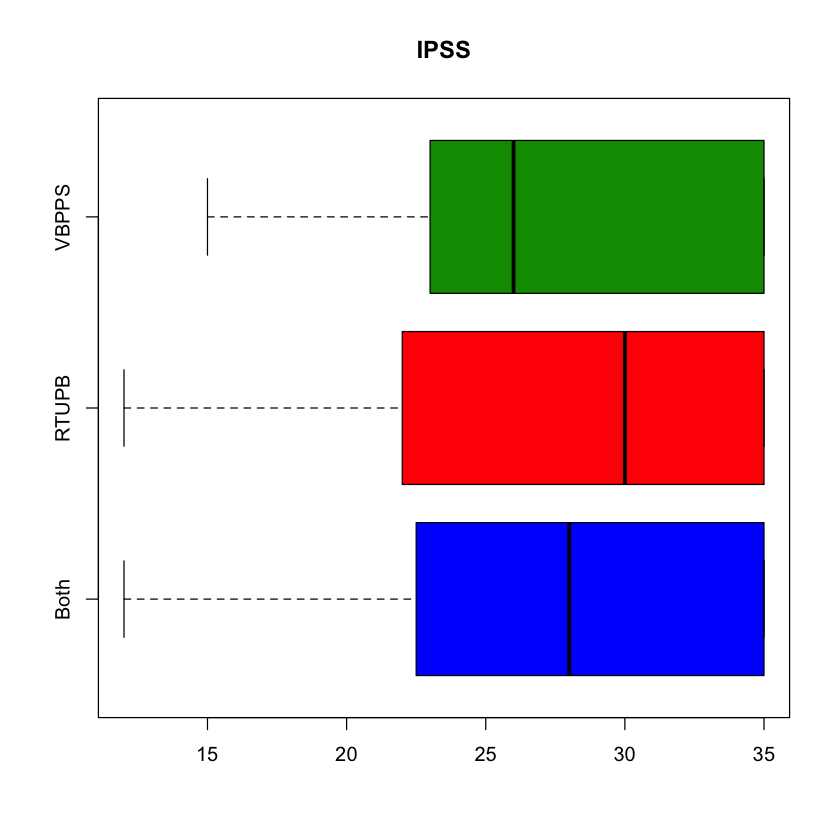

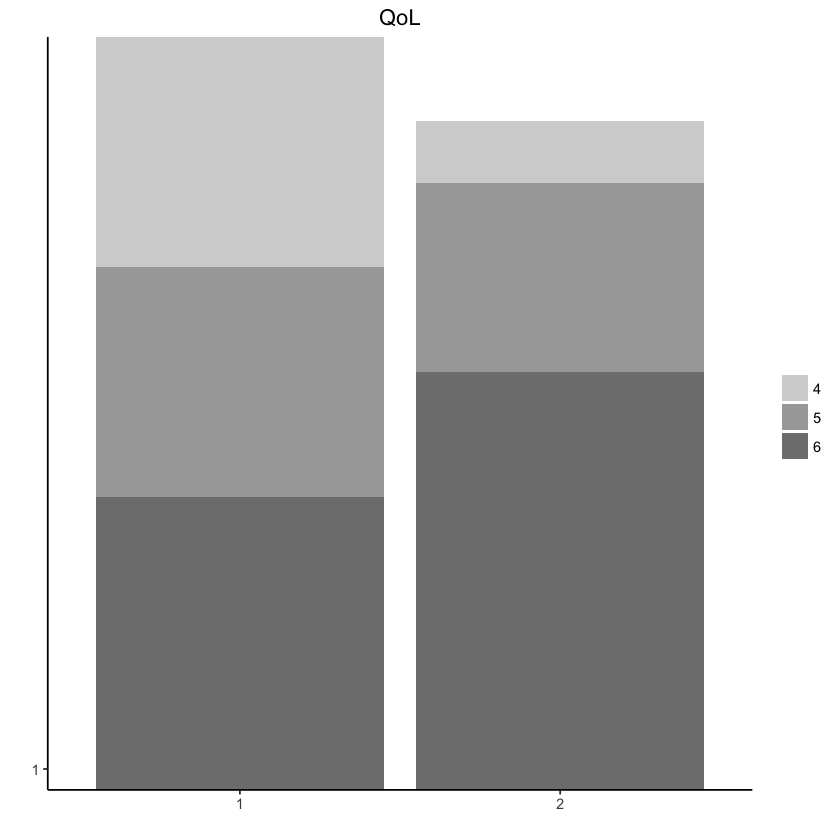

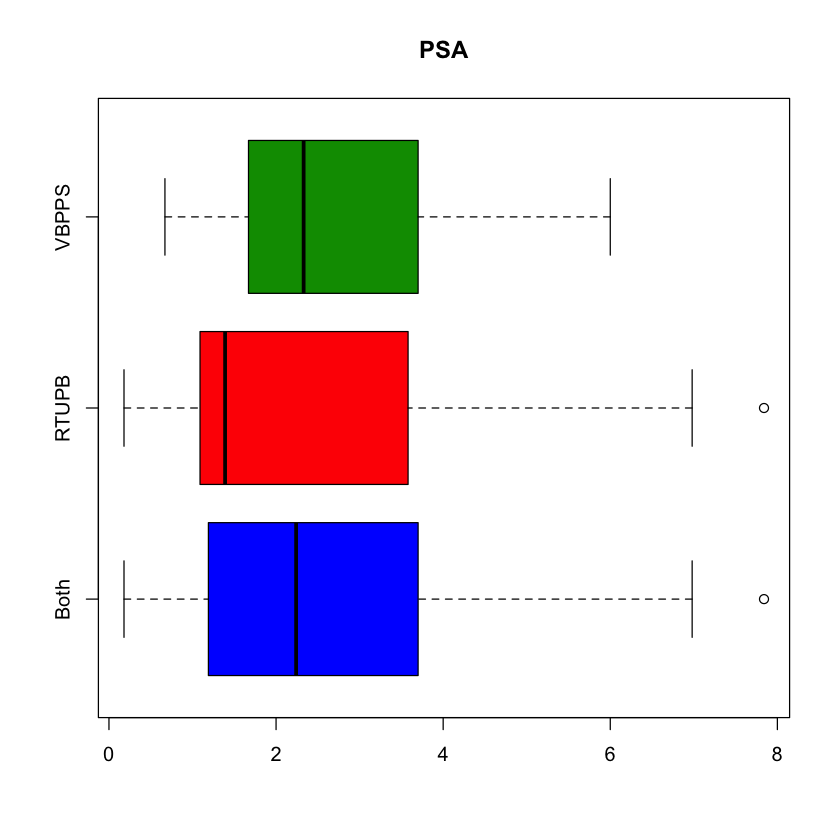

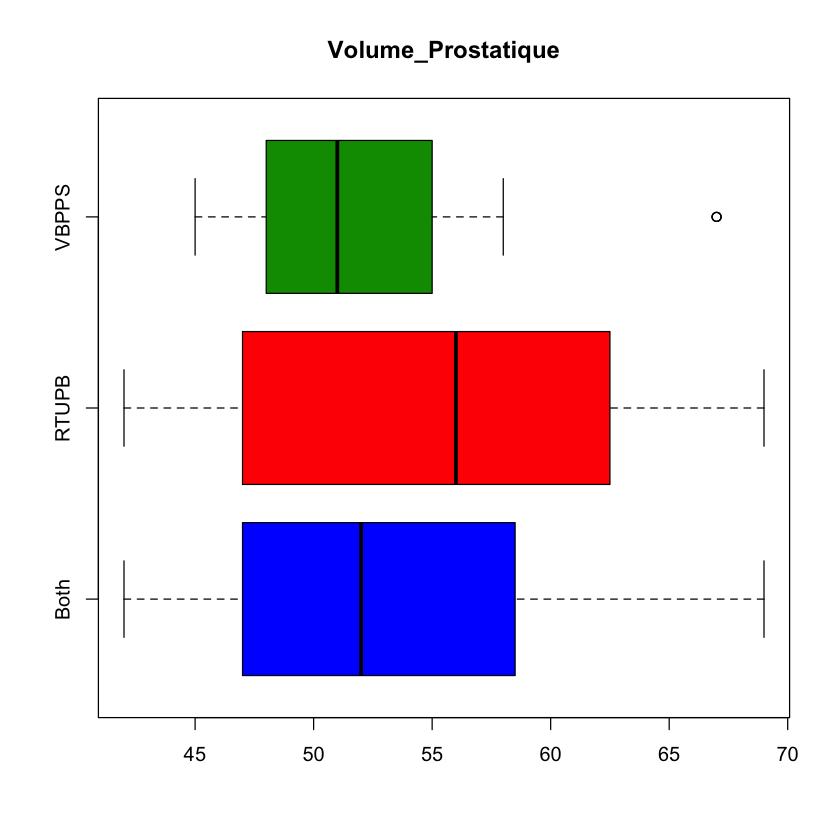

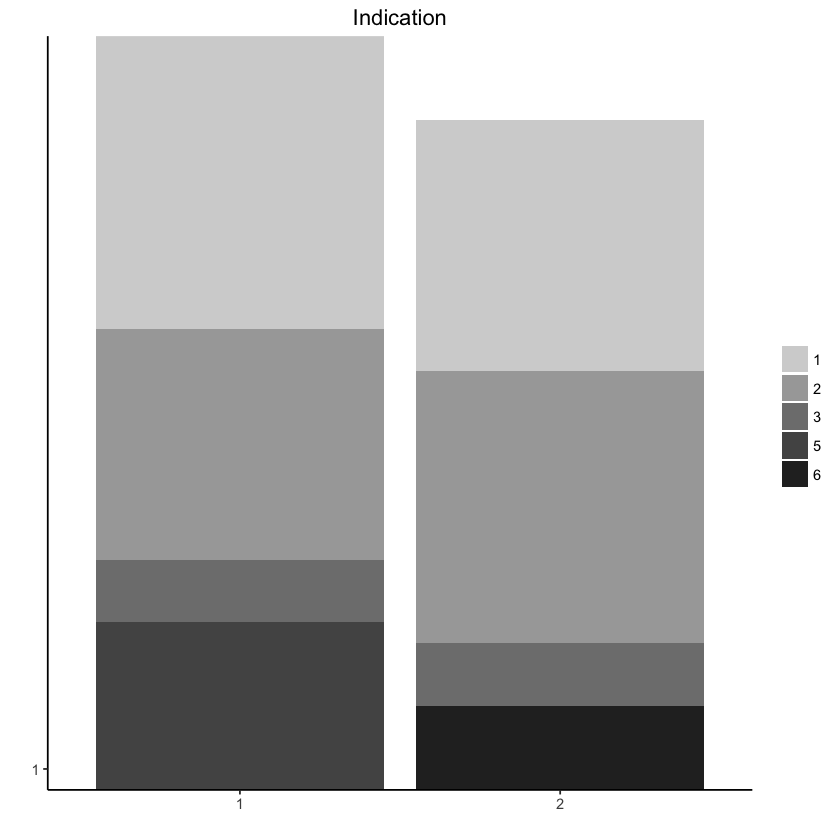

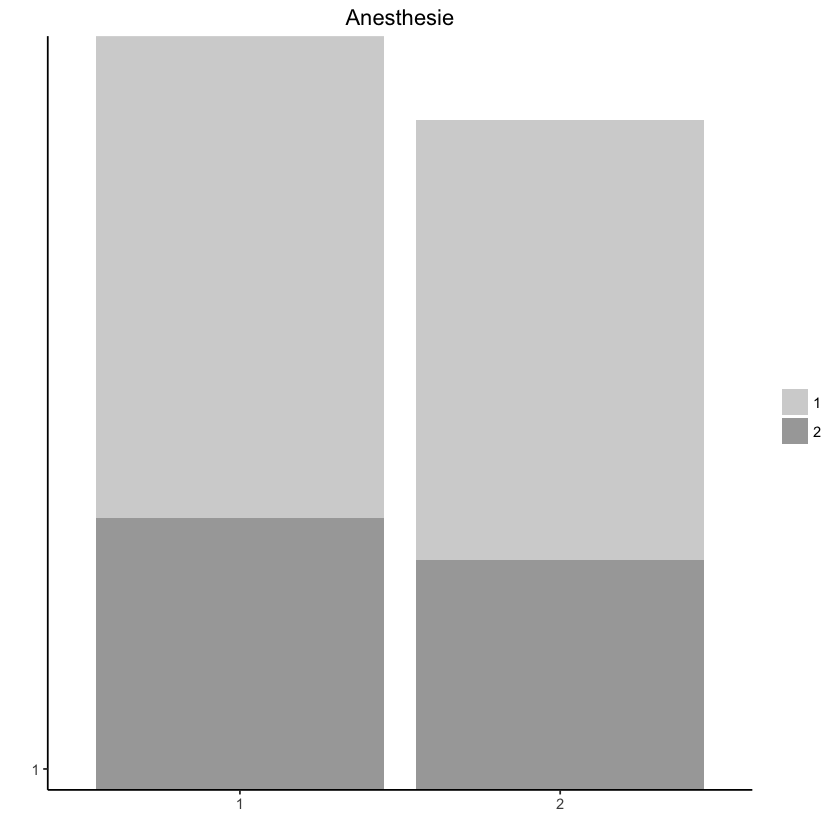

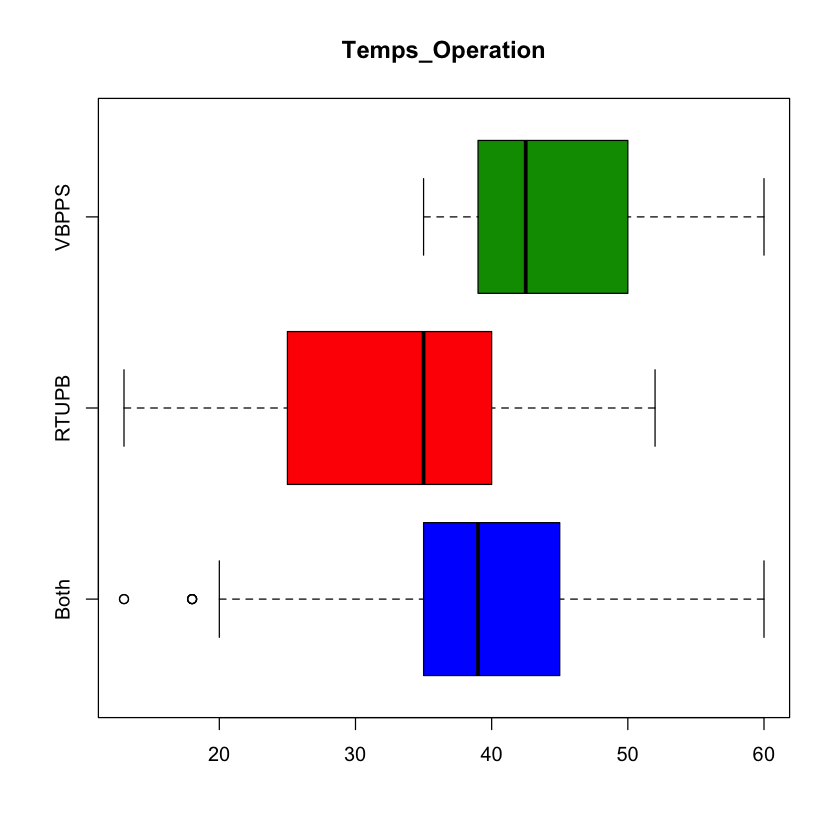

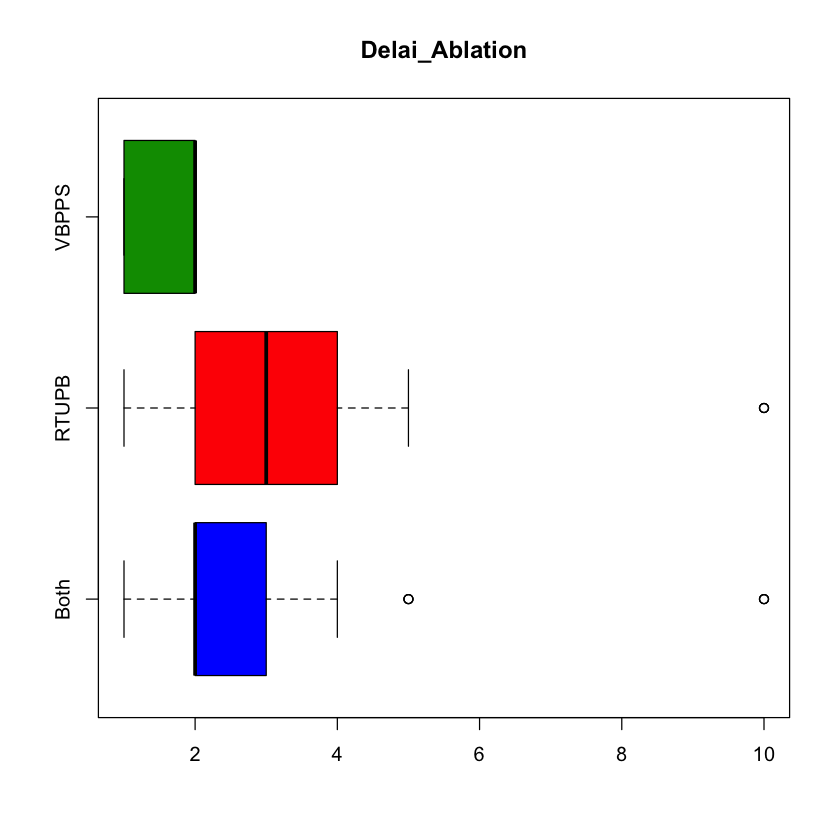

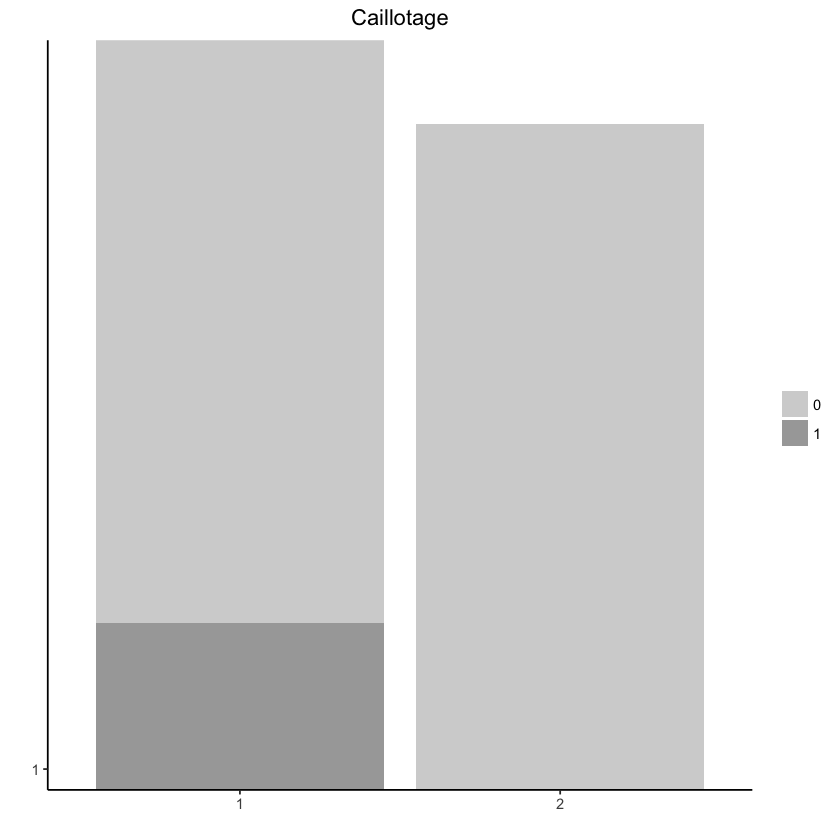

In [26]:
# Barplots des variables catégoriques
fill <- c("#d3d3d3", "#a8a8a8", "#7e7e7e", "#545454", "#2a2a2a")

for (i in 1:ncol(rtupb_vbpps_pre)) {
    # Boxplots des variables numériques
    if (is.numeric(rtupb_vbpps_pre[,i]))
        boxplot(rtupb_vbpps_pre[,i], rtupb_pre[,i], vbpps_pre[,i],
            names=c("Both","RTUPB","VBPPS"),horizontal=TRUE,main=colnames(rtupb_vbpps_pre)[i], col=c("blue","red","#009900"))
    else
        if (colnames(rtupb_vbpps_pre)[i] != "Technique"){
            # Stacked barplots des variables catégoriques
            p4 <- ggplot() + geom_bar(aes(y = factor(1), x = Technique, fill = rtupb_vbpps_pre[,i]), data = rtupb_vbpps_pre,
                stat="identity") +
                theme(legend.title = element_blank(), plot.title = element_text(hjust = 0.5)) +
                scale_fill_manual(values=fill) + labs(x="", y="") + ggtitle(colnames(rtupb_vbpps_pre)[i])
            print(p4)
    }
}

### 2.1.3 Corrélations

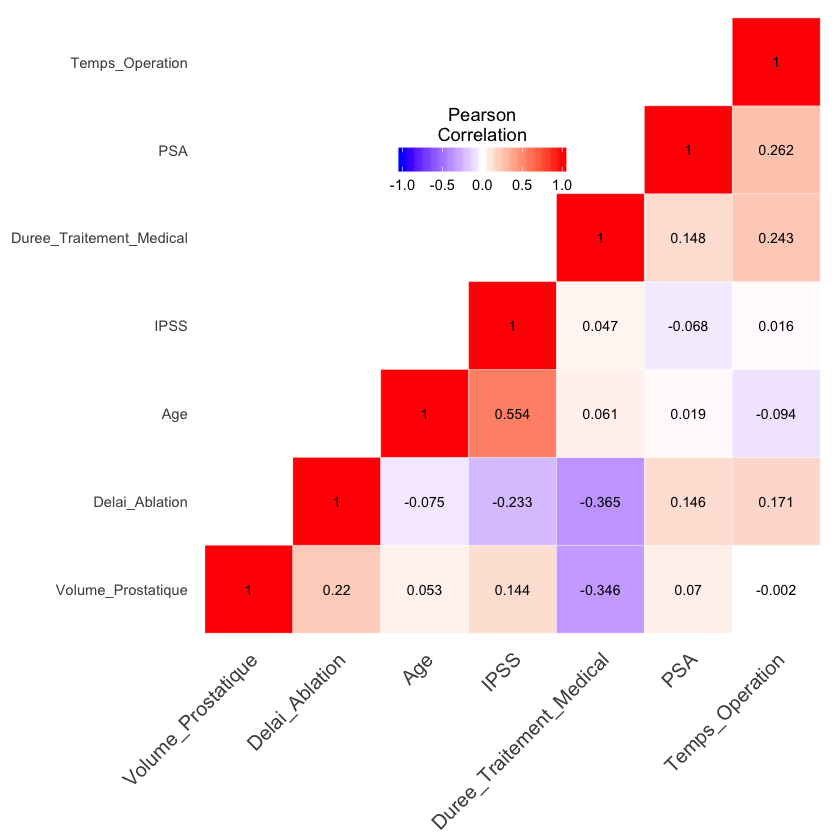

In [27]:
mat_cor = cor(rtupb_vbpps_pre_num, method = c("pearson"))
adenome_heatmap(mat_cor)


Pour les techniques RTUPB-VBPSS, en pré-opératoire, nous notons une faible corrélation négative entre Durée du traitement médical et les variables suivantes :
- Délai Ablation
- Volume Prostatique

Voici les scatterplots de ces croisements de variables.

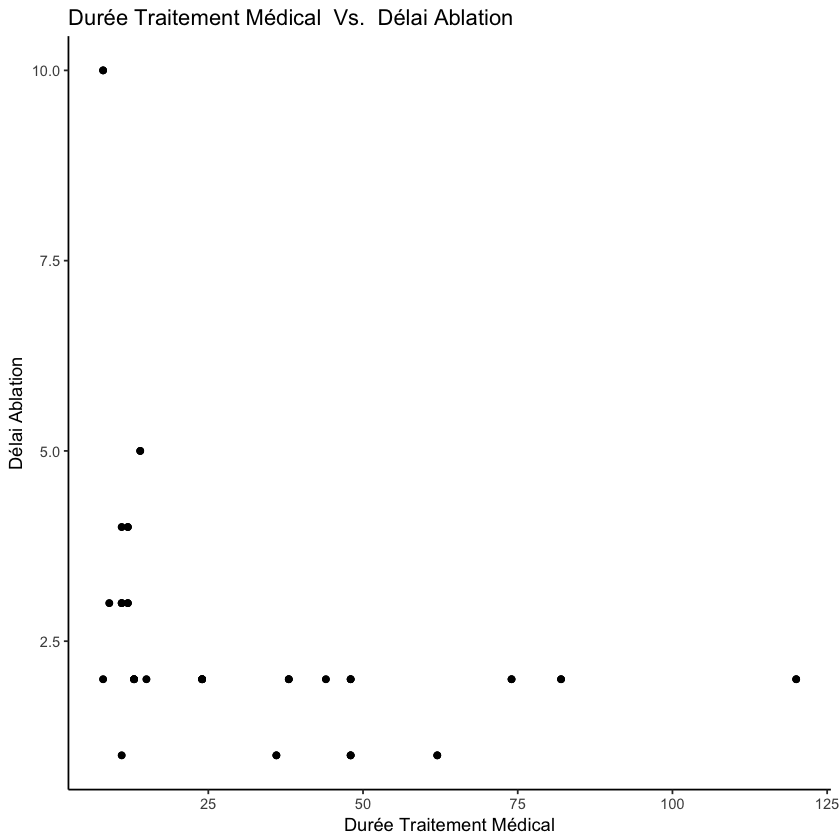

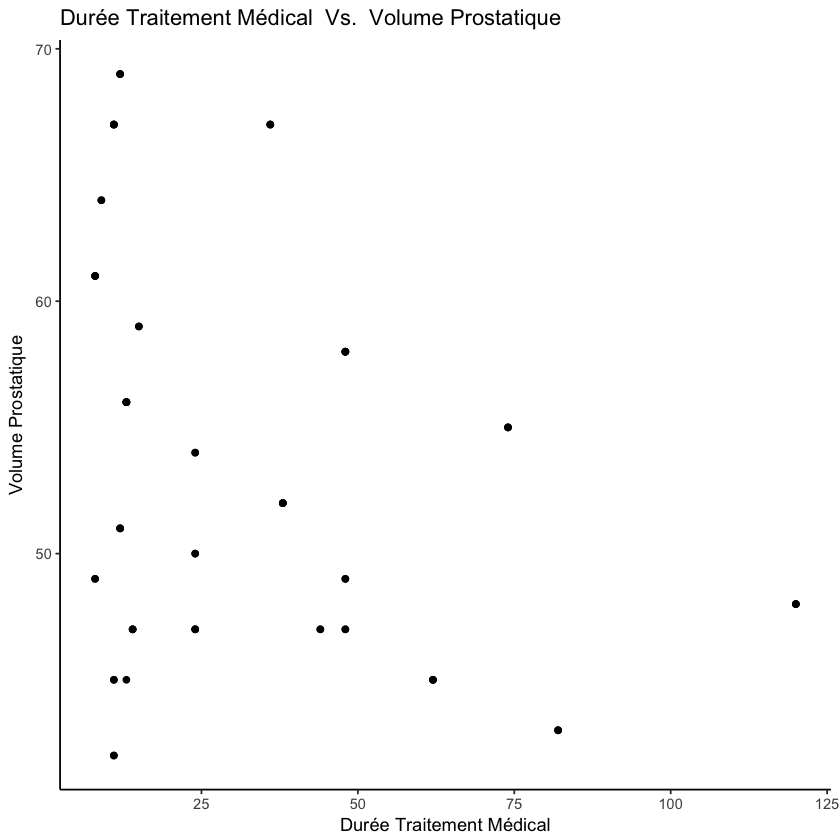

In [28]:
adenome_scatterplot(rtupb_vbpps_pre_num,rtupb_vbpps_pre_num$Duree_Traitement_Medical,rtupb_vbpps_pre$Delai_Ablation,"Durée Traitement Médical","Délai Ablation")
adenome_scatterplot(rtupb_vbpps_pre,rtupb_vbpps_pre$Duree_Traitement_Medical,rtupb_vbpps_pre$Volume_Prostatique,"Durée Traitement Médical","Volume Prostatique")

Egalement nous notons une corrélation positive entre Age et IPSS. Plus le patient est âgé, plus le traitement médical est long.

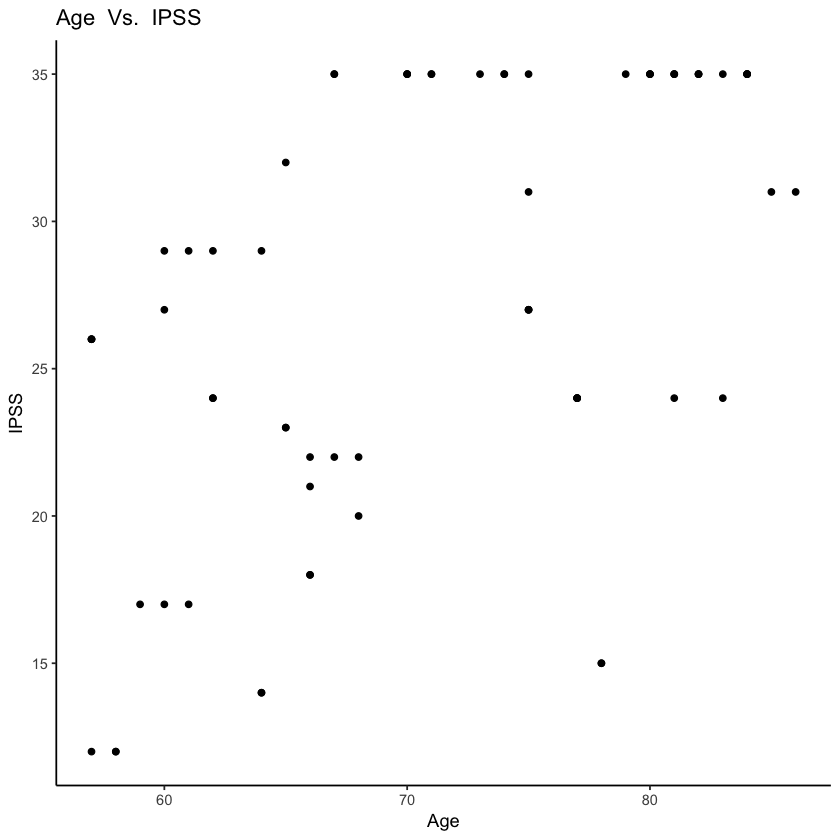

In [29]:
adenome_scatterplot(rtupb_vbpps_pre,rtupb_vbpps_pre$Age,rtupb_vbpps_pre$IPSS,"Age","IPSS")

### 2.1.4 Analyse en composantes principales

In [113]:
pca <- stats::prcomp(x=rtupb_vbpps_pre_num)
summary(pca)
pca

Importance of components:
                           PC1     PC2      PC3     PC4     PC5     PC6     PC7
Standard deviation     28.9872 11.1153 10.23448 7.24254 5.31293 1.88110 1.55134
Proportion of Variance  0.7274  0.1070  0.09067 0.04541 0.02444 0.00306 0.00208
Cumulative Proportion   0.7274  0.8343  0.92501 0.97042 0.99485 0.99792 1.00000

Standard deviations (1, .., p=7):
[1] 28.987207 11.115347 10.234475  7.242539  5.312925  1.881103  1.551342

Rotation (n x k) = (7 x 7):
                                 PC1         PC2          PC3         PC4
Age                       0.01898265 -0.37552831 -0.681422331  0.24500822
Duree_Traitement_Medical  0.98842259 -0.08216567  0.037719514 -0.11844545
IPSS                      0.01280296 -0.19604827 -0.566151509  0.01060137
PSA                       0.01045054  0.03909815 -0.018452553 -0.02173991
Volume_Prostatique       -0.10041931  0.05724351 -0.250312744 -0.94913479
Temps_Operation           0.10845775  0.89795901 -0.388212843  0.15607326
Delai_Ablation           -0.02324221  0.05154133 -0.002671434 -0.01187076
                                  PC5          PC6         PC7
Age                      -0.576277566 -0.039567160  0.02431736
Duree_Traitement_Medical -0.009882847 -0.001534525 -0.02678588
IPSS                      0.794257346  0.073171265 -0.06754610
PSA                

In [31]:
sum(100 * (pca$sdev^2)[1:2] / sum(pca$sdev^2))

[1] 83.43365

Ainsi les deux premières composantes à elles seules représentent 83% de l'information.

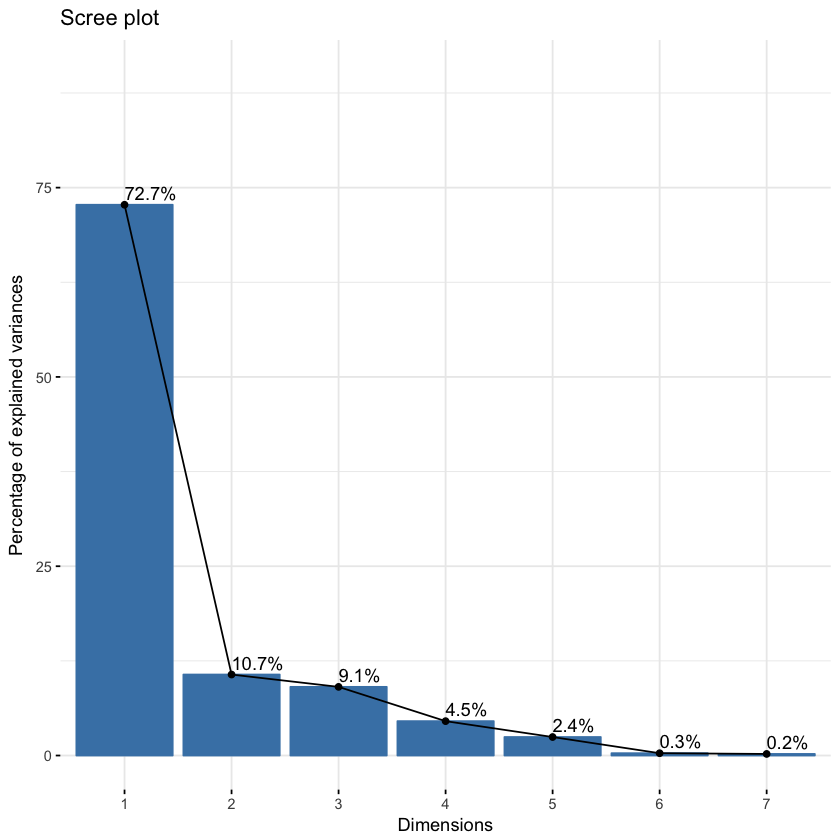

In [32]:
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 90))

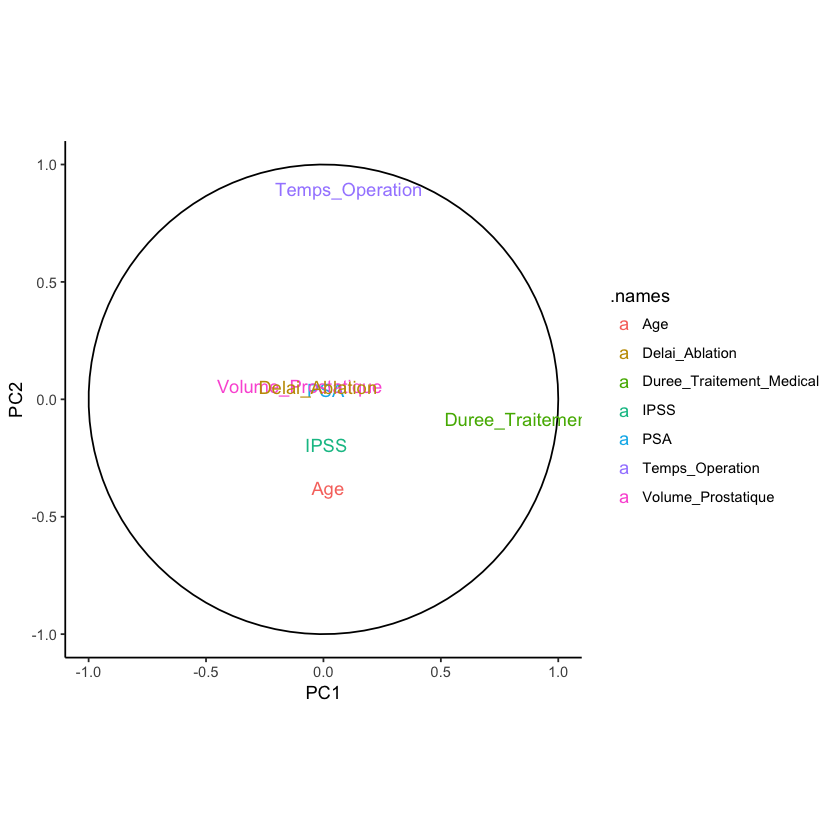

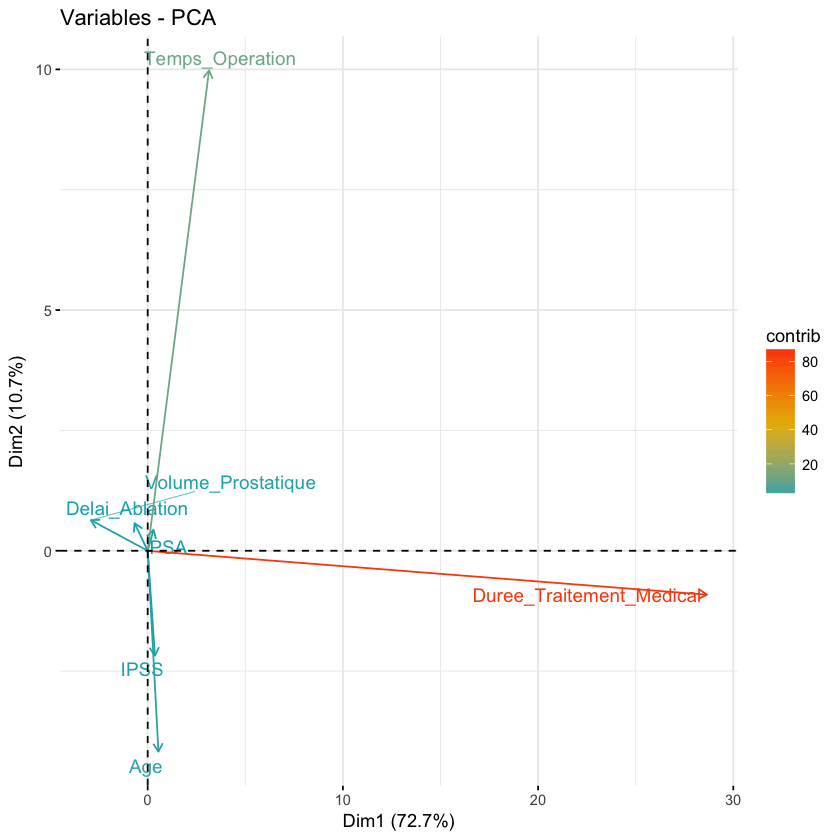

In [112]:
library("factoextra")
theta <- seq(0,2*pi,length.out = 100)
circle <- data.frame(x = cos(theta), y = sin(theta))
p <- ggplot(circle,aes(x,y)) + geom_path()
loadings <- data.frame(pca$rotation, 
.names = row.names(pca$rotation))
p + geom_text(data=loadings, 
mapping=aes(x = PC1, y = PC2, label = .names, colour = .names)) +
  coord_fixed(ratio=1) +
  labs(x = "PC1", y = "PC2")

fviz_pca_var(pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Évite le chevauchement de texte
             )

En observant le graphe ci-dessus on peut déduire que la variable qui contribue le plus dans la PC1 est "Durée du traitement médical". 
Les variables qui contribuent le plus à la PC2 sont "Temps Opération" et, à l'opposé, "IPSS" et "Age".

## 2.2 Post-opératoire

### 2.2.1 Distributions

In [ ]:
# Boxplots des variables numériques et barplots des variables catégoriques

for (i in 1:ncol(rtupb_post)) {
  if (is.numeric(rtupb_post[,i]) || is.integer(rtupb_post[,i])) {
    adenome_boxplot(rtupb_post,i,"RTUPB-VBPSS Post-operatoire")
  }
  else
    adenome_barplot(rtupb_post,i,"RTUPB-VBPSS Post-operatoire")
}

In [ ]:
### .2.2.2 Corrélations entre les variables Post-Opératoire

In [ ]:
plot(rtupb_cat_post)
plot(rtupb_num_post)

# 3. Clustering des données RTUPB-VBPPS

## 3.1 Extraction des profils types de patients à partir des données pré-opératoires

### 3.1.1 CAH

Commençons par afficher le dendrogramme pour nous permettre d'avoir une première intuition pour le nombre de classes.
Nous prenons soin de retirer la variable "Technique" de notre recherche de clustering car nous allons chercher à étudier cette variable plus tard dans l'analyse. Il ne serait pas correct de l'utiliser pour calculer les dissimilarités.

In [45]:
require(cluster)
library(fpc)

# On ne prend pas en compte la variable Technique dans le clustering
mat <- subset(rtupb_vbpps_pre,select=-c(Technique))

# On crée notre matrice de dissimilarité utilisant daisy car matrice hétérogène
gower_dist = daisy(mat, metric = "gower")

summary(gower_dist)
gower_mat <- as.matrix(gower_dist)

2278 dissimilarities, summarized :
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2784  0.3832  0.3716  0.4639  0.7351 
Metric :  mixed ;  Types = I, N, I, N, I, O, I, I, N, N, I, I, N 
Number of objects : 68

In [46]:
# Afin de vérifier le bon déroulement, nous pouvons comparer les 2 individus les plus proches
mat[which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]), arr.ind = TRUE)[1, ], ]

# et les 2 individus les plus éloignés
mat[which(gower_mat == max(gower_mat[gower_mat != max(gower_mat)]), arr.ind = TRUE)[1, ], ]

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,PSA,Volume_Prostatique,Indication,Anesthesie,Temps_Operation,Delai_Ablation,Caillotage
32,86,1,82,0,31,5,1.19,43,5,1,20,2,0
2,85,1,82,0,31,5,1.19,43,5,1,20,2,0


,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,PSA,Volume_Prostatique,Indication,Anesthesie,Temps_Operation,Delai_Ablation,Caillotage
16,79,1,9,1,35,6,6.00,64,1,1,30,3,1
12,64,0,11,0,14,4,1.09,42,5,2,13,1,0


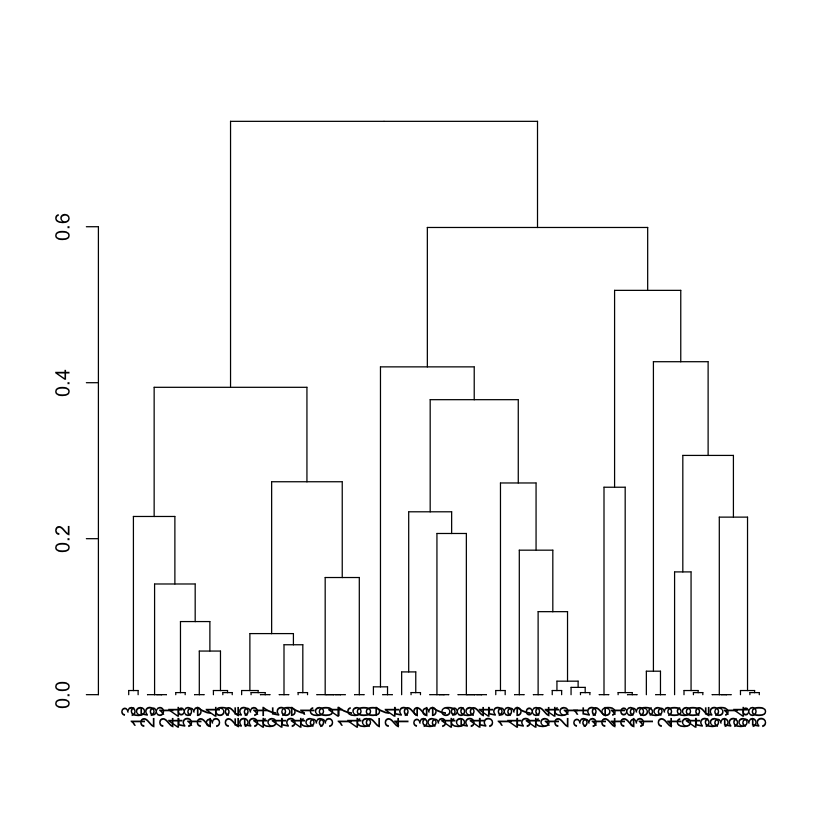

In [83]:
## Traçé du dendogramme
cah_pre_op <- hclust(gower_dist)

plot(as.dendrogram(cah_pre_op))

En regardant le dendrogramme, nous pouvons évaluer un nombre de classes de 3 ou 4.

### 3.1.2 PAM

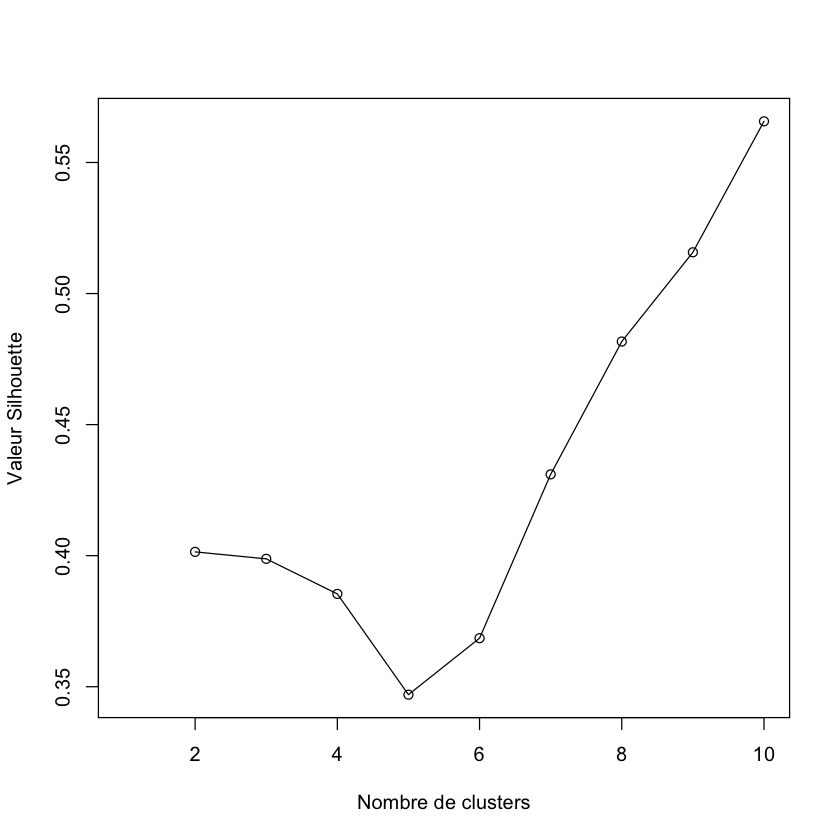

In [39]:
# Calculate silhouette width for many k using PAM
sil_width <- c(NA)

for(i in 2:10){
  pam_fit <- pam(gower_dist, diss = TRUE, k = i)
  sil_width[i] <- pam_fit$silinfo$avg.width
}

# Plot sihouette width (higher is better)

plot(1:10, sil_width, xlab = "Nombre de clusters", ylab = "Valeur Silhouette")
lines(1:10, sil_width)

Cette première tentative de clustering n'est pas concluante. Il faut un nombre très important de classes pour avoir des valeurs silhouette proches de 1. Pour être au delà de 0.7, valeur communément admise comme silhouette moyenne acceptable, il faut avoir plus de 10 classes. Par la suite, il sera très difficile d'interpréter un si grand nombre de classes. 

En général, il n'est pas intéressant, voire contre-productif, d'avoir 1 nombre de clusters supérieur à 10% de la population. Dans notre cas, cela signifie que nous ne devrions pas aller au-delà de 6 classes.

Jusqu'à 6 classes, les valeurs silhouettes les plus importantes sont pour 2 et 3 classes. En recoupant avec l'intuition apportée par le dendrogramme, nous pensons que 3 classes est un bon choix.

Pour 3 classes, nous avons une répartition plutôt homogène des individus.

In [43]:
k.optimal = 3

pam <- pam(gower_dist, diss = TRUE, k = k.optimal, metric = "gower")
pam$clusinfo

size,max_diss,av_diss,diameter,separation
24,0.3380102,0.1985036,0.4203080,0.2659938
26,0.2702409,0.1395546,0.3941044,0.2741430
18,0.3195286,0.2347373,0.5184103,0.2659938


In [ ]:
De plus, la répartition des techniques opératoires par profil de patient est idéale.

In [109]:
tab_cont <- table(rtupb_vbpps_clus$pam.clustering, rtupb_vbpps_clus$Technique,dnn = c('Cluster','Technique'))
tab_cont

       Technique
Cluster  1  2
      1 13 11
      2 14 12
      3  9  9

Nous faisons donc le choix de 3 profils de patients.

In [84]:
cat("Ci-dessous, une visualisation en 2D des", k.optimal, "clusters selon les 2 premières composantes principales.")

Ci-dessous, une visualisation en 2D des 3 clusters selon les 2 premières composantes principales.

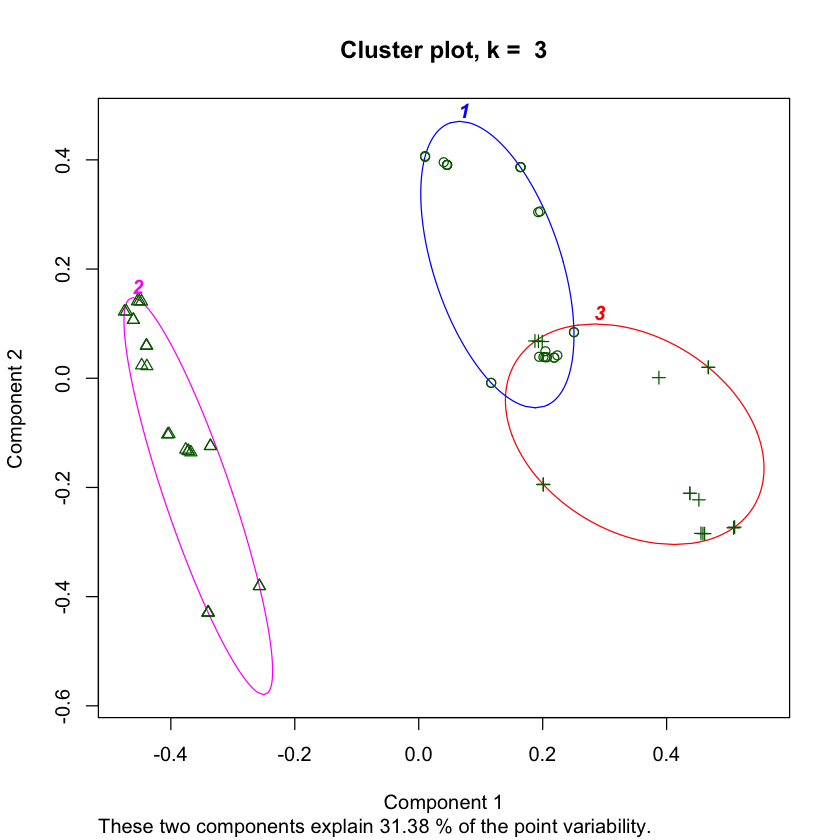

In [85]:
clusplot(pam, main = paste("Cluster plot, k = ", k.optimal), color = TRUE,lines=0,labels=5,span=TRUE,stand=FALSE)

### 3.1.3 Caractérisation des patients médoids

In [72]:
rtupb_vbpps_pre[pam$medoids,]

,Age,Comorbidite,Duree_Traitement_Medical,Porteur_Sonde,IPSS,QoL,PSA,Volume_Prostatique,Indication,Anesthesie,Technique,Temps_Operation,Delai_Ablation,Caillotage
14,64,0,13,0,29,5,0.18,56,2,1,1,35,2,0
55,75,0,38,1,35,6,3.70,52,1,1,2,39,2,0
10,68,0,13,0,20,4,7.84,45,2,2,1,34,2,0


### 3.1.4 Visualisation des distributions du Q_max à 12 mois pour les différentes classes

In [111]:
# Ajout du cluster aux datasets complets
rtupb_vbpps_clus <- data.frame(rtupb_vbpps, pam$clustering)

rtupb_clus <- rtupb_vbpps_clus[which(rtupb_vbpps_clus$Technique == 1),]
vbpps_clus <- rtupb_vbpps_clus[which(rtupb_vbpps_clus$Technique == 2),]

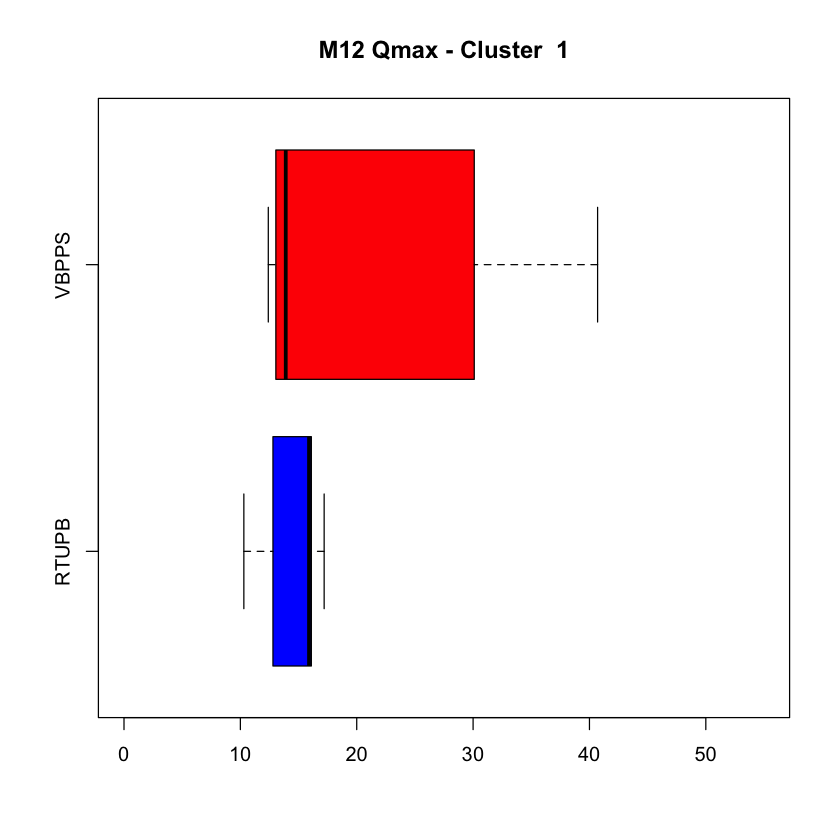

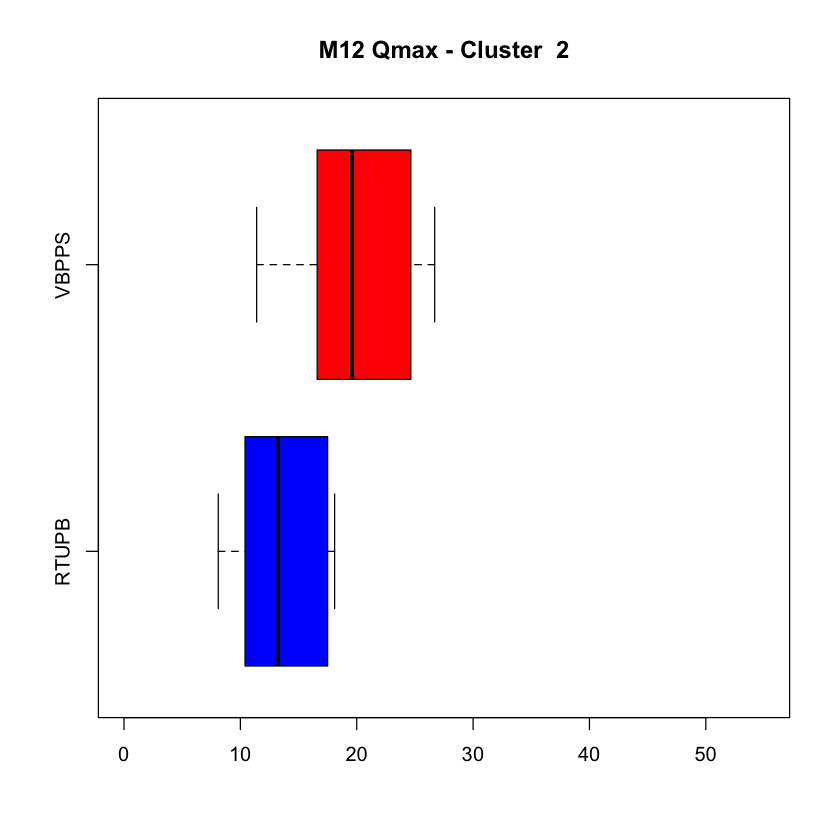

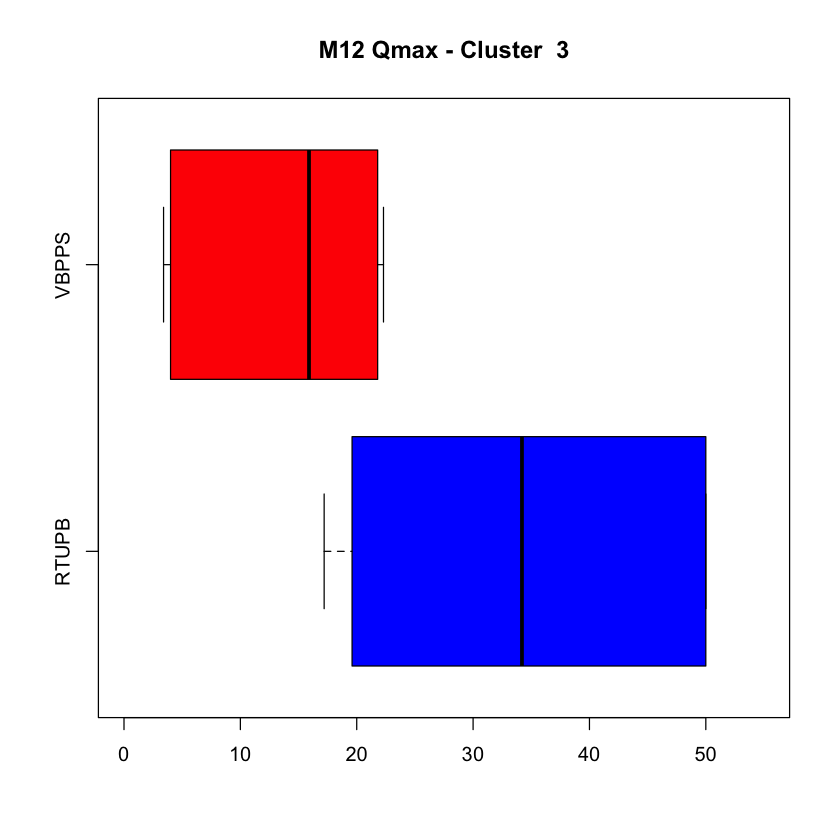

In [69]:
for (i in 1:k.optimal) {
    boxplot(rtupb_clus[which(rtupb_clus$pam.clustering == i),'M12_Qmax'],
            vbpps_clus[which(vbpps_clus$pam.clustering == i),'M12_Qmax'],
            names=c("RTUPB","VBPPS"),horizontal=TRUE,main=paste("M12 Qmax - Cluster ", i), col=c("blue","red"),
           ylim=c(0,55))
}

Un individu qui appartiendrait au cluster 3 aurait une miction de meilleure qualité à 12 mois si il a subi la tecnique RTUPB.
Inversement, un individu qui appartiendrait au cluster 2 aurait une meilleure miction à 12 mois si il subi la technique opératoire VBPPS.

## 3.2 Extraction des profils types des patients à partir des données post-opératoires¶
### 3.2.1 PAM

In [ ]:
# On crée une matrice de séries temporelles
matrix_series = cbind(t(vapor_num_post_series_qmax),t(vapor_num_post_series_ipss),t(vapor_cat_post_series_QoL))

### 3.2.2 CAH

### 3.2.3 Caractérisation des patients médoids

## 3.3 Classification supervisée